## Random Forest Implementation on scaled reduced dataset with LDA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [4]:
df_lda = pd.read_csv('../../DimensionalityReductionData/lda.csv')

Keep only the 'averageRating' column and join with LD1 from LDA

In [5]:
df_scaled = df_scaled[['averageRating']]
df_scaled['LD1'] = df_lda['LD1']

In [6]:
df_scaled.head()

,averageRating,LD1
0,1,-0.773971
1,0,-0.931000
2,1,1.084941
3,0,-0.681546
4,0,0.045055


Take sample for (initial) tests

In [7]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [8]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [9]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.6522318454363758
F1 score: [0.65926893 0.64489796]


## Grid Search CV - 1

In [11]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [12]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                               params  mean_test_score
54  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725697
58  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725614
42  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725614
50  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725448
39  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725114
43  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725114
51  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.724948
46  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.724781
55  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.724781
38  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.724698


Metrics for RF-LDA-GS-CV1:
Accuracy: 0.7268
Weighted F1: 0.7269
Weighted Precision: 0.7269
Weighted Recall: 0.7268
Macro-Averaged Precision: 0.7265
Macro-Averaged Recall: 0.7266
F1: [0.73582474 0.71724138]
Precision: [0.7377261  0.71526823]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.73      0.74      1556
     Class 1       0.72      0.72      0.72      1446

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


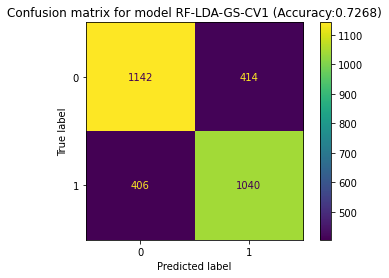

In [13]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-LDA-GS-CV1', y_test, predictions)

In [14]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7268487674883412
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7285143237841439
Parameters from place:  2   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7278481012658228
Parameters from place:  3   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7278481012658228
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7258494337108594
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples_l

In [15]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [16]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.7285143237841439
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [17]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7709287796751354
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7674302374010828
Parameters from place:  2   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7698458975426905
Parameters from place:  3   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7717617659308621
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7740108288213244
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples_l

In [18]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=seed, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

Accuracy for max depth : 14   0.8305705955851729
Accuracy for max depth : 13   0.814993752603082
Accuracy for max depth : 12   0.8011661807580175
Accuracy for max depth : 11   0.7854227405247813
Accuracy for max depth : 10   0.7732611411911704
Accuracy for max depth : 9   0.7650145772594752
Accuracy for max depth : 8   0.7551020408163265
Accuracy for max depth : 7   0.7496043315285298
Accuracy for max depth : 6   0.7441899208663058
Accuracy for max depth : 5   0.7432736359850063
Accuracy for max depth : 4   0.7392753019575177
Accuracy for max depth : 3   0.7353602665556018
Accuracy for max depth : 2   0.736109954185756
Accuracy for max depth : 1   0.7361932528113286


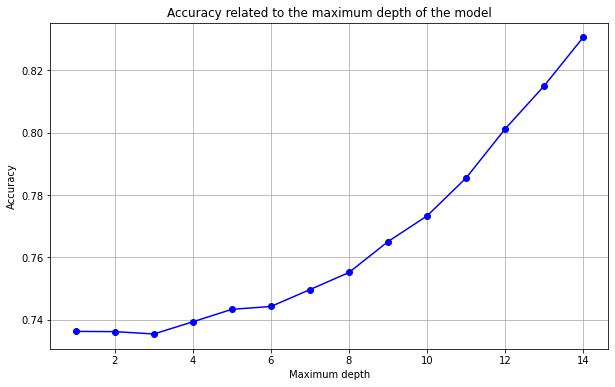

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [20]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=random_state_fit)
  

  model = RandomForestClassifier(random_state=seed, **best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.7308461025982678
0.7201865423051299
0.7331778814123917
0.729180546302465
0.729180546302465
0.737508327781479
0.7341772151898734
0.7288474350433045
0.7211858760826116
0.7165223184543638
0.7301798800799467
0.7161892071952032
0.7208527648234511
0.7225183211192538
0.7311792138574283
0.7311792138574283
0.723850766155896
0.7418387741505663
0.7258494337108594
0.7308461025982678
0.7295136575616256
0.7251832111925383
0.7301798800799467
0.729180546302465
0.7378414390406396
0.7348434377081945
0.7245169886742172
0.7301798800799467
0.7305129913391073
0.7318454363757495
0.7131912058627582
0.7251832111925383
0.7411725516322452
0.7225183211192538
0.7395069953364424
0.7218520986009327
0.7298467688207861
0.7275149900066622
0.7225183211192538
0.7271818787475016
0.7208527648234511
0.7415056628914057
0.737508327781479
0.7205196535642905
0.7395069953364424
0.7235176548967355
0.7418387741505663
0.7338441039307129
0.7208527648234511
0.7278481012658228
0.7298467688207861
0.7251832111925383
0.7215189873417721

Metrics for RF-LDA-Shuffled_best:
Accuracy: 0.7452
Weighted F1: 0.7448
Weighted Precision: 0.7459
Weighted Recall: 0.7452
Macro-Averaged Precision: 0.7461
Macro-Averaged Recall: 0.7447
F1: [0.75629181 0.73298429]
Precision: [0.7345297  0.75757576]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.78      0.76      1523
     Class 1       0.76      0.71      0.73      1479

    accuracy                           0.75      3002
   macro avg       0.75      0.74      0.74      3002
weighted avg       0.75      0.75      0.74      3002

Confusion Matrix


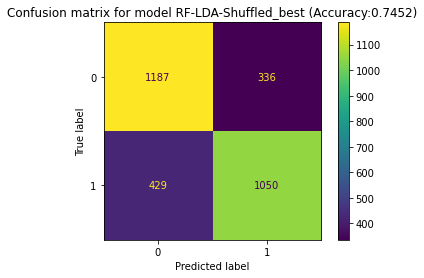

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
RF-LDA-Shuffled_best,0.74517,0.744809,0.745884,0.74517,0.746053,0.744661,[0.75629181 0.73298429],[0.7345297 0.75757576]


In [21]:
calculate_metrics('RF-LDA-Shuffled_best', y_best_predictions, best_predictions)